In [1]:
import numpy as np
import h5py

import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

import json
import os

## South Africa

### Counts

In [2]:
data_dir = '/work/ka1176/shared_data/2021-ai4food/raw_data/'

In [3]:
south_africa_tr_labels_dir_1 = os.path.join(data_dir, 'ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_258N/labels.geojson')
south_africa_tr_labels_dir_2 = os.path.join(data_dir, 'ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_259N/labels.geojson')
south_africa_te_labels_dir = os.path.join(data_dir, 'ref_fusion_competition_south_africa_test_labels/ref_fusion_competition_south_africa_test_labels_34S_20E_259N/labels.geojson')

In [4]:
#CHECK TARGET DATA FORMAT IN TRAINING GROUND-TRUTH POLYGONS:
south_africa_tr_labels_1=gpd.read_file(south_africa_tr_labels_dir_1)
south_africa_tr_labels=south_africa_tr_labels_1.append(gpd.read_file(south_africa_tr_labels_dir_2))
print('INFO: Number of fields: {}\n'.format(len(south_africa_tr_labels)))
south_africa_te_labels=gpd.read_file(south_africa_te_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(south_africa_te_labels)))

INFO: Number of fields: 4151

INFO: Number of fields: 2417



In [5]:
south_africa_tr_labels = south_africa_tr_labels.sort_values('crop_id')

In [6]:
colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 

In [7]:
value_counts = south_africa_tr_labels['crop_name'].value_counts(sort=False)
value_counts

Wheat                   753
Barley                  661
Canola                  512
Lucerne/Medics         1792
Small grain grazing     433
Name: crop_name, dtype: int64

In [8]:
df = pd.DataFrame(dict(crop_counts=value_counts.values, crop_names=value_counts.index))

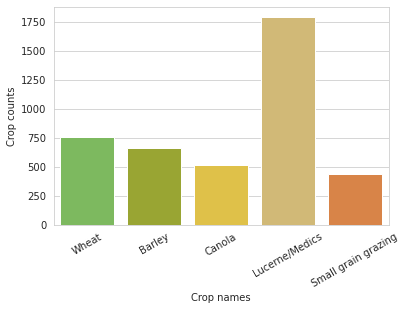

In [9]:
sns.set_style('whitegrid')
ax=sns.barplot(data=df, x='crop_names', y='crop_counts', palette=sns.color_palette(colors_list))
ax.set_xlabel('Crop names')
ax.set_xticks(range(5))
ax.set_xticklabels(value_counts.index, rotation=30)
ax.set_ylabel('Crop counts')
plt.savefig('fig_south_africa_crop_id_barplot.png', dpi=150, bbox_inches="tight")

### Bands

In [10]:
train_data = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/south-africa/planet-5/extracted/train_data.h5', 'r')
image_stack = train_data['image_stack'][:]
labels = train_data['label'][:]

crop_ids, inv_idx, counts = np.unique(labels, return_inverse=True, return_counts=True)

for u,c in zip(crop_ids, counts):
    print(f'Crop ID {u}: {c} samples')
    
def calc_ndvi(image_stack):
    nir = image_stack[:, 3]
    red = image_stack[:, 2]
    
    ndvi = (nir - red) / (nir + red)
    
    ndvi = np.nan_to_num(ndvi)
    
    return ndvi

Crop ID 1: 751 samples
Crop ID 2: 660 samples
Crop ID 3: 512 samples
Crop ID 4: 1788 samples
Crop ID 5: 432 samples


1
2
3
4
5


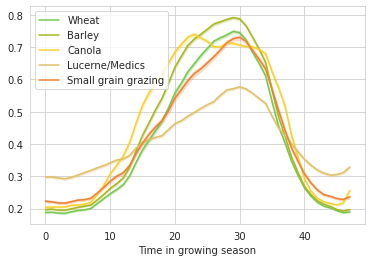

In [11]:
fig, axx = plt.subplots(1, 1, sharex=True, sharey=True, figsize=[6, 4])

for crop_id in range(1, 6):
    print(crop_id)
    ix = np.where(labels==crop_id)[0]

    crop_ndvi = np.empty([len(ix)+1, 48, 64])
    crop_ndvi[:] = None

    for j,i in enumerate(ix):
        img = image_stack[i]
        crop_ndvi[j] = calc_ndvi(img)
        
    m_ndvi = np.nanmean(crop_ndvi, axis=(0,2))
    s_ndvi = np.nanstd(crop_ndvi, axis=(0,2)) / np.sqrt(len(ix))
    
    axx.plot(range(48), m_ndvi, color=colors_list[crop_id-1], label=pd.unique(df.crop_names)[crop_id-1])
    axx.fill_between(range(48), m_ndvi + s_ndvi, m_ndvi, alpha=0.2, color=colors_list[crop_id-1])
    axx.fill_between(range(48), m_ndvi - s_ndvi, m_ndvi, alpha=0.2, color=colors_list[crop_id-1])

    axx.legend()
    axx.set_xlabel('Time in growing season')

plt.savefig('fig_south_africa_crop_id_ndvi.png', dpi=150, bbox_inches="tight")

### Submission

In [12]:
with open('/work/ka1176/caroline/jobs/ai4food/training_i10_k-fold/submission_planet_sentinel-1_i10_10-fold_ordered.json') as sf:
    best_submission = json.load(sf)

In [13]:
df = pd.DataFrame.from_dict(best_submission)
df.columns = ['fid', 'predicted_crop_id', 'predicted_crop_name', 'crop_probs']

In [14]:
new_df = south_africa_te_labels.merge(df, on='fid')
new_df = new_df.sort_values('predicted_crop_id')
new_df

,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry,predicted_crop_id,predicted_crop_name,crop_probs
2071,190718,80462.435513,1615.582024,0,No Data,"MULTIPOLYGON (((498973.109 6220022.977, 499063...",1,Wheat,"[0.4991227016, 0.0046040832, 0.0026587597, 0.0..."
2007,190654,44734.495543,1018.982836,0,No Data,"MULTIPOLYGON (((501065.758 6222913.633, 500936...",1,Wheat,"[0.7044706915, 0.2462688953, 0.0025774535, 0.0..."
2008,190655,132472.811329,1720.241130,0,No Data,"MULTIPOLYGON (((500764.133 6222996.976, 500653...",1,Wheat,"[0.6043426484, 0.3598911401, 0.0060061147, 0.0..."
2009,190656,130036.863665,1613.471408,0,No Data,"MULTIPOLYGON (((500266.054 6223473.889, 500242...",1,Wheat,"[0.6727162167, 0.1889154477, 0.0050838424, 0.0..."
526,187115,133987.885838,3357.042623,0,No Data,"MULTIPOLYGON (((486356.099 6233892.495, 486370...",1,Wheat,"[0.5517116114, 0.0431709532, 0.0035587968, 0.1..."
...,...,...,...,...,...,...,...,...,...
542,187131,151009.991038,2176.207788,0,No Data,"MULTIPOLYGON (((489613.567 6233817.154, 489619...",5,Small grain grazing,"[0.19770748, 0.0233112402, 0.014832611, 0.0332..."
544,187133,196536.976604,1890.049276,0,No Data,"MULTIPOLYGON (((489226.613 6233542.649, 489233...",5,Small grain grazing,"[0.1099777987, 0.0093240007, 0.0076599477, 0.3..."
545,187134,44419.900457,858.855876,0,No Data,"MULTIPOLYGON (((488598.667 6233917.564, 488555...",5,Small grain grazing,"[0.0982335889, 0.0069383775, 0.0024676338, 0.3..."
531,187120,47347.624941,1573.697022,0,No Data,"MULTIPOLYGON (((489948.927 6231565.678, 489939...",5,Small grain grazing,"[0.210061523, 0.0083426859, 0.0080956227, 0.21..."


Wheat
Barley
Canola
Lucerne/Medics
Small grain grazing


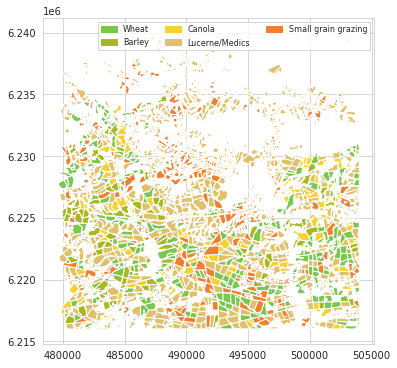

In [15]:

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

legend_elements = []

for group, color in zip(new_df.groupby('predicted_crop_name', sort=False), colors_list):
    print(group[0])
    group[1].plot(ax=ax, color=color)
    legend_elements.append(Patch(facecolor=color, edgecolor=color,label=group[0]))
    
ax.legend(handles=legend_elements,loc=1, ncol=3, fontsize=8)

plt.savefig('fig_south_africa_predictions_map.png', dpi=150, bbox_inches="tight")

## Germany

### Counts

In [16]:
data_dir = '/work/ka1176/shared_data/2021-ai4food/raw_data/'

In [17]:
germany_train_labels_dir = os.path.join(data_dir, 'dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/labels.geojson')
germany_test_labels_dir = os.path.join(data_dir, 'dlr_fusion_competition_germany_test_labels/dlr_fusion_competition_germany_test_labels_33N_17E_243N/labels.geojson')

In [18]:
#CHECK TARGET DATA FORMAT IN TRAINING GROUND-TRUTH POLYGONS:
germany_train_labels=gpd.read_file(germany_train_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(germany_train_labels)))
germany_test_labels=gpd.read_file(germany_test_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(germany_test_labels)))

INFO: Number of fields: 2534

INFO: Number of fields: 2064



In [19]:
germany_train_labels = germany_train_labels.sort_values('crop_id')

In [20]:
colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 

In [21]:
value_counts = germany_train_labels['crop_name'].value_counts(sort=False)
value_counts

Wheat           305
Rye             279
Barley          137
Oats             45
Corn            251
Oil Seeds       201
Root Crops       23
Meadows         954
Forage Crops    339
Name: crop_name, dtype: int64

In [22]:
df = pd.DataFrame(dict(crop_counts=value_counts.values, crop_names=value_counts.index))

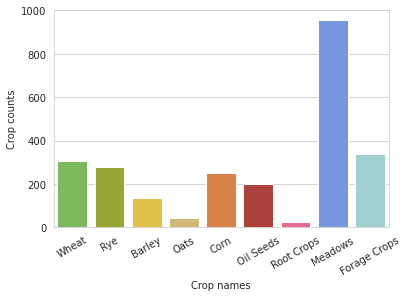

In [23]:
sns.set_style('whitegrid')
ax=sns.barplot(data=df, x='crop_names', y='crop_counts', palette=sns.color_palette(colors_list))
ax.set_xlabel('Crop names')
ax.set_xticks(range(9))
ax.set_xticklabels(value_counts.index, rotation=30)
ax.set_ylabel('Crop counts')
plt.savefig('fig_germany_crop_id_barplot.png', dpi=150, bbox_inches="tight")

### Bands

In [24]:
train_data = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/germany/planet-5/extracted/train_data.h5', 'r')
image_stack = train_data['image_stack'][:]
labels = train_data['label'][:]

crop_ids, inv_idx, counts = np.unique(labels, return_inverse=True, return_counts=True)

for u,c in zip(crop_ids, counts):
    print(f'Crop ID {u}: {c} samples')
    
def calc_ndvi(image_stack):
    nir = image_stack[:, 3]
    red = image_stack[:, 2]
    
    ndvi = (nir - red) / (nir + red)
    
    ndvi = np.nan_to_num(ndvi)
    
    return ndvi

Crop ID 1: 302 samples
Crop ID 2: 276 samples
Crop ID 3: 136 samples
Crop ID 4: 44 samples
Crop ID 5: 248 samples
Crop ID 6: 201 samples
Crop ID 7: 21 samples
Crop ID 8: 943 samples
Crop ID 9: 333 samples


1
2
3
4
5
6
7
8
9


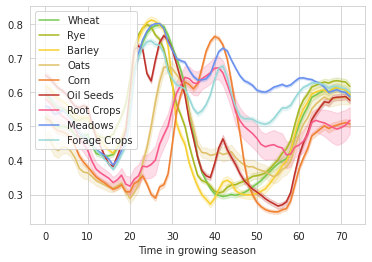

In [25]:
fig, axx = plt.subplots(1, 1, sharex=True, sharey=True, figsize=[6, 4])

for crop_id in range(1, 10):
    print(crop_id)
    ix = np.where(labels==crop_id)[0]

    crop_ndvi = np.empty([len(ix)+1, 73, 64])
    crop_ndvi[:] = None

    for j,i in enumerate(ix):
        img = image_stack[i]
        crop_ndvi[j] = calc_ndvi(img)
        
    m_ndvi = np.nanmean(crop_ndvi, axis=(0,2))
    s_ndvi = np.nanstd(crop_ndvi, axis=(0,2)) / np.sqrt(len(ix))
    
    axx.plot(range(73), m_ndvi, color=colors_list[crop_id-1], label=pd.unique(df.crop_names)[crop_id-1])
    axx.fill_between(range(73), m_ndvi + s_ndvi, m_ndvi, alpha=0.2, color=colors_list[crop_id-1])
    axx.fill_between(range(73), m_ndvi - s_ndvi, m_ndvi, alpha=0.2, color=colors_list[crop_id-1])

    axx.legend()
    axx.set_xlabel('Time in growing season')

plt.savefig('fig_germany_crop_id_ndvi.png', dpi=150, bbox_inches="tight")

### Submission

In [26]:
with open('/work/ka1176/caroline/jobs/ai4food/training_germany_debug/submission.json') as sf:
    best_submission = json.load(sf)

In [27]:
df = pd.DataFrame.from_dict(best_submission)
df.columns = ['fid', 'predicted_crop_id', 'predicted_crop_name', 'crop_probs']

In [28]:
new_df = germany_test_labels.merge(df, on='fid')
new_df = new_df.sort_values('predicted_crop_id')
new_df

,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry,predicted_crop_id,predicted_crop_name,crop_probs
647,93768,120561.163576,1835.112948,0,No Data,"MULTIPOLYGON (((408000.000 5841688.320, 408026...",1,Wheat,"[0.4681607589, 0.1638918821, 0.0178367439, 0.0..."
1766,168629,597353.109548,3703.504835,0,No Data,"MULTIPOLYGON (((420542.020 5838110.590, 420542...",1,Wheat,"[0.9178158641, 0.0315045625, 0.0318468313, 0.0..."
486,92903,74561.082473,1581.246771,0,No Data,"MULTIPOLYGON (((409877.320 5835799.140, 410268...",1,Wheat,"[0.8975713134, 0.0075290259, 0.0468551045, 0.0..."
1768,168674,175135.122273,1678.890948,0,No Data,"MULTIPOLYGON (((429236.120 5847762.930, 429235...",1,Wheat,"[0.5415312529, 0.4083519727, 0.0122270716, 0.0..."
469,92818,108045.588172,1336.663455,0,No Data,"MULTIPOLYGON (((408387.980 5842185.440, 408380...",1,Wheat,"[0.3567418709, 0.0300086316, 0.0177307482, 0.0..."
...,...,...,...,...,...,...,...,...,...
1593,165606,39828.597800,1017.124737,0,No Data,"MULTIPOLYGON (((425165.290 5847535.040, 425165...",9,Crops,"[0.0703136246, 0.0331639659, 0.0092792365, 0.0..."
961,108185,14908.655253,701.704141,0,No Data,"MULTIPOLYGON (((430442.520 5853327.840, 430412...",9,Crops,"[0.0962592207, 0.0763310775, 0.0776592389, 0.0..."
960,108182,23673.461604,639.762916,0,No Data,"MULTIPOLYGON (((430348.600 5853212.760, 430348...",9,Crops,"[0.2233711861, 0.1080672834, 0.0300694526, 0.0..."
966,108331,3354.197200,265.745681,0,No Data,"MULTIPOLYGON (((430771.050 5853558.480, 430788...",9,Crops,"[0.2302800412, 0.0125681653, 0.0162581371, 0.0..."


Wheat
Rye
Barley
Oats
Corn
Oil
Seeds
Root
Crops


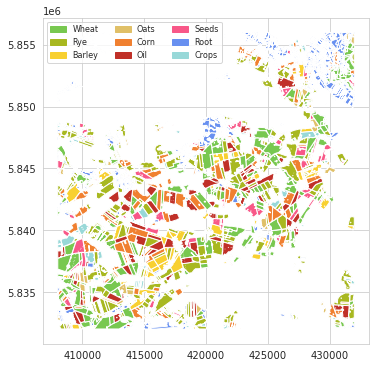

In [29]:

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

legend_elements = []

for group, color in zip(new_df.groupby('predicted_crop_name', sort=False), colors_list):
    print(group[0])
    group[1].plot(ax=ax, color=color)
    legend_elements.append(Patch(facecolor=color, edgecolor=color,label=group[0]))
    
ax.legend(handles=legend_elements,loc=2, ncol=3, fontsize=8)

plt.savefig('fig_germany_predictions_map.png', dpi=150, bbox_inches="tight")